# Random Forest Classifier 

Random Forest Classifier Steps: <br>
- Load Main Dataset <br>
- Split in Dataset for training and testing <br>
- Build Bootstrapped Dataset <br>
- Train Decision Trees on those datasets using diferent groups of features<br>
- Get Test Data and for each entry on the table make it go through all the trees and take note of the results<br>
- Agregate all the results from the different trees and choose the best value thorugh majority voting<br>
            


## Library imports

In [12]:
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, explained_variance_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from matplotlib import pyplot 

from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz


#mainpath="C:\\Users\\alexa\\Desktop\\github\\Project-LabIACD\\metadata.csv"
mainpath="C:\\Users\\alexa\\Desktop\\Tudo\\Aulas\\LABS\\Project-LabIACD\\pylidc_grouped.csv"

## Load Main Dataset

In [13]:
main_dataset=pd.read_csv(mainpath)
main_dataset.tail()


,Subtlety,Internalstructure,Calcification,Sphericity,Margin,Lobulation,Spiculation,Texture,Malignancy,Malignancy_round
2646,4.333333,1.0,6.0,3.666667,2.333333,2.333333,3.0,3.333333,4.0,4
2647,2.500000,1.0,6.0,4.500000,2.000000,1.000000,1.5,1.000000,3.5,4
2648,3.000000,1.0,6.0,3.500000,3.500000,1.500000,1.0,5.000000,3.5,4
2649,5.000000,1.0,6.0,4.000000,5.000000,1.000000,1.0,5.000000,2.0,2
2650,5.000000,1.0,4.0,5.000000,5.000000,3.000000,3.0,5.000000,2.5,3


## Spliting Training and Testing Datasets

We are firstly going to make the data division based on Pareto´s Law (80% training/20% testing) <br>
And Later maybe try the division acording to the paper "A scaling law
for the validation-set training-set size ratio" by Isabelle Guyon

In [14]:
collumn_name='Malignancy_round'
features_collumns=main_dataset.drop(collumn_name,axis=1)
features_collumns=features_collumns.drop('Malignancy',axis=1)
has_cancer_collumns=main_dataset[collumn_name]

features_treino, features_teste, has_cancer_treino, has_cancer_teste=train_test_split(features_collumns,has_cancer_collumns, test_size=0.2)
#has_cancer_collumns
#features_collumns

## Random Forest Classifier

Although we say in the index that we have to build the Bootstrapped Dataset the sklearn random forest classifier has the ability to do that for us alowing us to skip a step<br>
<br>
In this chapter we´ll have some sub-chapters so that we can play around with the random Forest Classifier to try and get the best possible model


### Default Random Forest

#### DataFitting

In [15]:
#RandomForest = RandomForestRegressor()
RandomForest = RandomForestClassifier()
RandomForest.fit(features_treino,has_cancer_treino)

RandomForestClassifier()

#### Model Evaluation

##### Prediction Part

In [16]:
has_cancer_prediction=RandomForest.predict(features_teste)

##### Accuracy Part

In [17]:
#accuracy= explained_variance_score(has_cancer_teste, has_cancer_prediction)
accuracy = accuracy_score(has_cancer_teste, has_cancer_prediction)
print(f"Accuracy = {accuracy} in a percentage of 100 = {accuracy*100}")

Accuracy = 0.6195856873822976 in a percentage of 100 = 61.95856873822976


### Model Tuning

Now let's see if by changing the parameters we can get a better solution<br>
<br>
With sklearn we have some comands that help us with this such as RandomizedSearchCV, but let´s first talk about the parameters we'll be messing with:<br>
-n_estimators: Represents the amount of Decision Trees in our Forest, we'll try to change the value in increments of 20 to try and find an "optimal" value between [50,400]<br>
-criterion: criterion in the trees we'll be testing gini vs entropy<br>
-max_features: the number of features that each tree will have, according to some studies the best values should be around $\sqrt{TotalFeatures}$ or log<sub>2</sub>(TotalFeatures)<br>
<br>
Note that this is only one proposal of a potential model for this problem where we are going to make some assumptions in order to find if those a are true.
<br>
The first of those is that we'll make the superficial and perhaps stupid assumption that if a parameter improves the accuracy when adjusted by himself that, the improvement is going to stack with the improvement that we get from tuning other parameter by themselfs.<br>
<br>
By the end we'll see if this assumption holds or not

#### Stackable Improvements Assumption

##### Finding the best Tree number

- For this we'll test the tree numbers in increments of 10 <br>
- Our accuracy score for each number of trees will be given by an average of 5 tests <br>
- After this we'll save the best value<br>

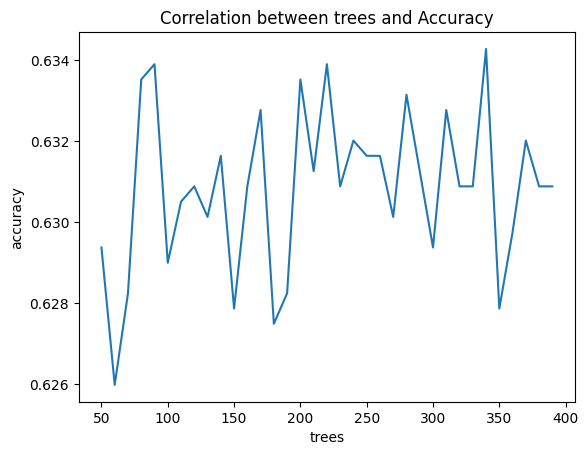

Best tree value=340


In [18]:
a=50
b=400
values=[]
treenumber=[]
for i in range (a,b,10):
    average_accuracy=0

    for k in range (5):
        RandomForest = RandomForestClassifier(n_estimators=i, n_jobs=(-1))
        RandomForest.fit(features_treino,has_cancer_treino)
        has_cancer_prediction=RandomForest.predict(features_teste)
        accuracy = accuracy_score(has_cancer_teste, has_cancer_prediction)
        average_accuracy+=accuracy
    values.append(average_accuracy/5)
    treenumber.append(i)

pyplot.plot(treenumber,values )
pyplot.xlabel('trees')
pyplot.ylabel('accuracy') 
pyplot.title('Correlation between trees and Accuracy')
pyplot.show() 

values=np.array(values)
index=np.where(values==np.max(values))
besttree=treenumber[index[0][0]]
print(f"Best tree value={besttree}")

##### Finding the best criterion

We'll test two criterion:<br>
- Gini<br>
- Entropy<br>
- Log Loss

In [38]:
accuracy_gini=0
accuracy_entropy=0
accuracy_logloss=0
for i in range (5):
    RandomForestGini = RandomForestClassifier(criterion="gini", n_jobs=(-1))
    RandomForestGini.fit(features_treino,has_cancer_treino)
    has_cancer_predictionGini=RandomForest.predict(features_teste)
    accuracy_gini_iter = accuracy_score(has_cancer_teste, has_cancer_predictionGini)
    accuracy_gini+=accuracy_gini_iter

    RandomForestEntropy = RandomForestClassifier(criterion="entropy", n_jobs=(-1))
    RandomForestEntropy.fit(features_treino,has_cancer_treino)
    has_cancer_predictionEntropy=RandomForest.predict(features_teste)
    accuracy_entropy_iter = accuracy_score(has_cancer_teste, has_cancer_predictionEntropy)
    accuracy_entropy+=accuracy_entropy_iter

    RandomForestlogloss = RandomForestClassifier(criterion="log_loss", n_jobs=(-1))
    RandomForestlogloss.fit(features_treino,has_cancer_treino)
    has_cancer_predictionlogloss=RandomForest.predict(features_teste)
    accuracy_logloss_iter = accuracy_score(has_cancer_teste, has_cancer_predictionlogloss)
    accuracy_logloss+=accuracy_logloss_iter

accuracy_gini=accuracy_gini/5
accuracy_entropy=accuracy_entropy/5
accuracy_logloss=accuracy_logloss/5


In [39]:
print(f"Accuracy = {accuracy_gini} in a percentage of 100 = {accuracy*100}")
print(f"Accuracy = {accuracy_entropy} in a percentage of 100 = {accuracy*100}")
print(f"Accuracy = {accuracy_logloss} in a percentage of 100 = {accuracy*100}")

Accuracy = 0.6629001883239172 in a percentage of 100 = 66.29001883239172
Accuracy = 0.6629001883239172 in a percentage of 100 = 66.29001883239172
Accuracy = 0.6629001883239172 in a percentage of 100 = 66.29001883239172


##### Finding the best minimum samples split

In [40]:
lower=2
upper=40
values=[]
samplesnumber=[]
for i in range (lower,upper):
    average_accuracy=0

    for k in range (5):
        RandomForest = RandomForestClassifier(min_samples_split=i, n_jobs=(-1))
        RandomForest.fit(features_treino,has_cancer_treino)
        has_cancer_prediction=RandomForest.predict(features_teste)
        accuracy = accuracy_score(has_cancer_teste, has_cancer_prediction)
        average_accuracy+=accuracy
    values.append(average_accuracy/5)
    samplesnumber.append(i)

values=np.array(values)
index=np.where(values==np.max(values))
bestsample=samplesnumber[index[0][0]]
print(f"Best Sample value={bestsample}, max accuracy={np.max(values)}")


Best Sample value=39, max accuracy=0.6677966101694917


##### Finding the best Tree deepth

In [ ]:
lower=2
upper=15
values=[]
samplesnumber=[]
for i in range (lower,upper):
    average_accuracy=0

    for k in range (5):
        RandomForest = RandomForestClassifier(max_depth=i, n_jobs=(-1))
        RandomForest.fit(features_treino,has_cancer_treino)
        has_cancer_prediction=RandomForest.predict(features_teste)
        accuracy = accuracy_score(has_cancer_teste, has_cancer_prediction)
        average_accuracy+=accuracy
    values.append(average_accuracy/5)
    samplesnumber.append(i)

values=np.array(values)
index=np.where(values==np.max(values))
bestsample=samplesnumber[index[0][0]]
print(f"Best Sample value={bestsample}, max accuracy={np.max(values)}")

###### Confusion Matrix

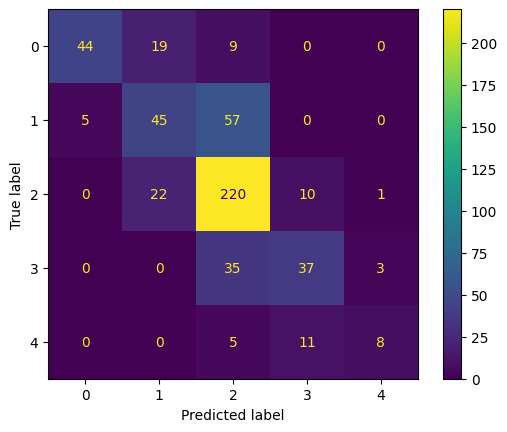

In [23]:
cm=confusion_matrix(has_cancer_teste, has_cancer_prediction)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
#True_positives, False_positives, True_negatives, False_negatives=confusion_matrix(has_cancer_teste, has_cancer_prediction).ravel
#print(f"True Positives={True_positives} \n False Positives={False_positives} \n True Negatives={True_negatives} \n False Positives={False_positives}")

We can observe that out model ussualy when it fails it tends to under label when label number > 2 and over label when label number <=2

#### Gini with Log and tree number

##### Find the best tree number for gini with log

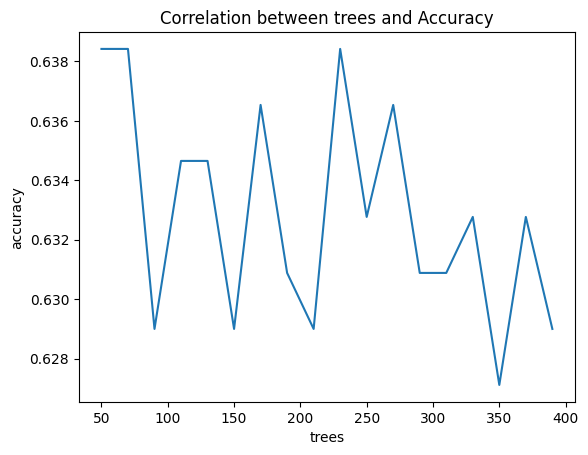

Best tree value=50


In [24]:
a=50
b=400
values=[]
treenumber=[]
for i in range (50,400,20):
    RandomForest = RandomForestClassifier(n_estimators=i,criterion="gini",max_features="log2", n_jobs=(-1))
    RandomForest.fit(features_treino,has_cancer_treino)
    has_cancer_prediction=RandomForest.predict(features_teste)
    accuracy = accuracy_score(has_cancer_teste, has_cancer_prediction)
    values.append(accuracy)
    treenumber.append(i)
pyplot.plot(treenumber,values )
pyplot.xlabel('trees')
pyplot.ylabel('accuracy') 
pyplot.title('Correlation between trees and Accuracy')
pyplot.show() 
values=np.array(values)
index=np.where(values==values.max())
besttree=treenumber[index[0][0]]
print(f"Best tree value={besttree}")

##### Model With Best Tree Number

In [25]:
RandomForest = RandomForestClassifier(n_estimators=besttree,criterion="gini",max_features="log2")
RandomForest.fit(features_treino,has_cancer_treino)
has_cancer_prediction=RandomForest.predict(features_teste)

###### Accuracy

In [26]:
accuracy = accuracy_score(has_cancer_teste, has_cancer_prediction)
print(f"Accuracy = {accuracy} in a percentage of 100 = {accuracy*100}")

Accuracy = 0.6290018832391714 in a percentage of 100 = 62.90018832391714


###### Precision

In [27]:
precision = precision_score(has_cancer_teste, has_cancer_prediction,average='weighted')
print(f"Precision = {precision} in a percentage of 100 = {precision*100}")

Precision = 0.6259955344565388 in a percentage of 100 = 62.599553445653875


###### Confusion Matrix

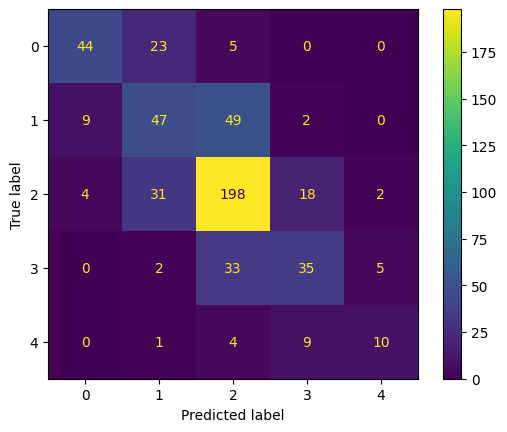

In [28]:
cm=confusion_matrix(has_cancer_teste, has_cancer_prediction)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
#True_positives, False_positives, True_negatives, False_negatives=cm.ravel
#print(f"True Positives={True_positives} \n False Positives={False_positives} \n True Negatives={True_negatives} \n False Positives={False_positives}")

#### Entropy with Square root and tree number

##### Find the best tree number for gini with square root

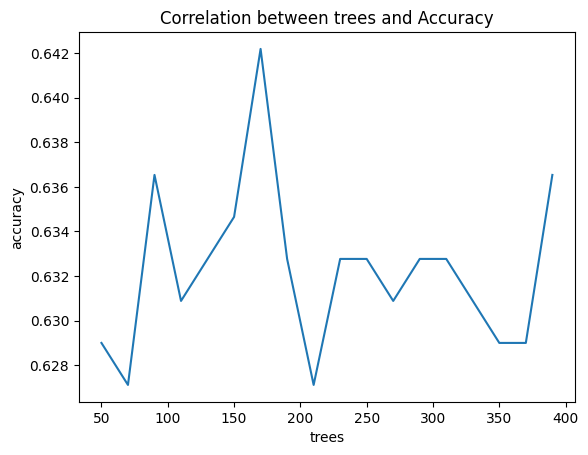

Best tree value=170


In [29]:
a=50
b=400
values=[]
treenumber=[]
for i in range (50,400,20):
    RandomForest = RandomForestClassifier(n_estimators=i,criterion="entropy",max_features="sqrt", n_jobs=(-1))
    RandomForest.fit(features_treino,has_cancer_treino)
    has_cancer_prediction=RandomForest.predict(features_teste)
    accuracy = accuracy_score(has_cancer_teste, has_cancer_prediction)
    values.append(accuracy)
    treenumber.append(i)
pyplot.plot(treenumber,values )
pyplot.xlabel('trees')
pyplot.ylabel('accuracy') 
pyplot.title('Correlation between trees and Accuracy')
pyplot.show() 
values=np.array(values)
index=np.where(values==values.max())
besttree=treenumber[index[0][0]]
print(f"Best tree value={besttree}")

##### Model With Best Tree Number

In [30]:
RandomForest = RandomForestClassifier(n_estimators=besttree,criterion="entropy",max_features="sqrt")
RandomForest.fit(features_treino,has_cancer_treino)
has_cancer_prediction=RandomForest.predict(features_teste)

###### Accuracy


In [31]:
accuracy = accuracy_score(has_cancer_teste, has_cancer_prediction)
print(f"Accuracy = {accuracy} in a percentage of 100 = {accuracy*100}")

Accuracy = 0.6346516007532956 in a percentage of 100 = 63.465160075329564


###### Precision

In [32]:
precision = precision_score(has_cancer_teste, has_cancer_prediction,average='weighted')
print(f"Precision = {precision} in a percentage of 100 = {precision*100}")

Precision = 0.6302248229112837 in a percentage of 100 = 63.02248229112837


###### Confusion Matrix

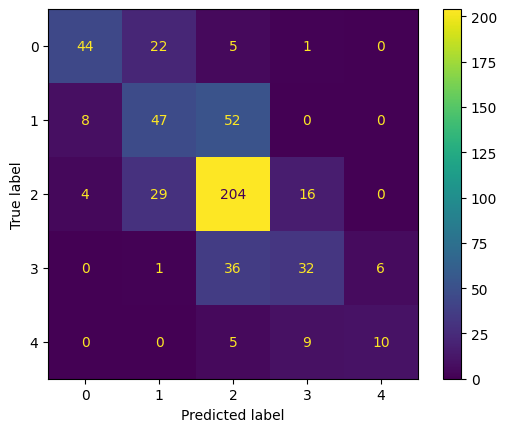

In [33]:
cm=confusion_matrix(has_cancer_teste, has_cancer_prediction)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
#True_positives, False_positives, True_negatives, False_negatives=cm.ravel
#print(f"True Positives={True_positives} \n False Positives={False_positives} \n True Negatives={True_negatives} \n False Positives={False_positives}")

In [ ]:
tree = RandomForest.estimators_[i]
dot_data = export_graphviz(tree,
                            feature_names=features_treino.columns,  
                            filled=True,  
                            max_depth=None, 
                            impurity=False, 
                            proportion=True)
graph = graphviz.Source(dot_data)
display(graph)